# Report

- The name of your AKS cluster
- The resource group name you used for your AKS cluster
- The storage account name for this Spark program
- The blob container name for this Spark program
- The service account name for this Spark program
- The Spark image for running Spark on AKS
- The URL for downloading the dataset(s) with a paragraph that provides a short description of the dataset(s).
  - **Link**: https://www.kaggle.com/datasets/harlfoxem/housesalesprediction
  - **Descrption**: The King County House Sales dataset offers a rich exploration of residential property transactions in the Seattle area. Spanning from May 2014 to May 2015, this collection provides a comprehensive snapshot of the local real estate market. With its focus on a specific urban region and timeframe, the dataset serves as an ideal foundation for developing and testing regression models in real estate price prediction. It presents an opportunity for analysts and data scientists to uncover patterns in housing valuations and hone their skills in predictive modeling within a practical, real-world context.

---

## Environment Preparing

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg, stddev, corr, desc
from pyspark.sql.window import Window
# Config to suppress warning
import warnings
warnings.filterwarnings("ignore")
os.environ['SPARK_LOCAL_IP'] = '192.168.0.106'
RUNNING = 'local' # 'online'

# Prepare dataset, paths
if RUNNING == 'local':
    cur_dir = os.getcwd()
    data_path = os.path.join(cur_dir, 'kc_house_data.csv')
    output_dir = os.path.join(cur_dir, 'output')
    chart_outputs = [
        os.path.join(output_dir, f'c{i}.png') for i in range(1, 5)
    ]
    question_outputs = [
        os.path.join(output_dir, f'q{i}.csv') for i in range(1, 5)
    ]
elif RUNNING == 'online':
    pass

In [2]:
# Create SparkSession
spark = SparkSession.builder \
    .appName("House Prices EDA") \
    .config("spark.executor.instances", "2") \
    .config("spark.executor.cores", "1") \
    .getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")
print(f"SparkSession created with name 'House Prices EDA', job started time: {time.ctime()}")

# Read the dataset
df = spark.read.csv(
    data_path,
    header=True,
    inferSchema=True
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/03 22:40:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


SparkSession created with name 'House Prices EDA', job started time: Sat Aug  3 22:40:20 2024


In [3]:
df.count()

21613

In [4]:
# Show the schema of the dataset
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



---

## Question 1: Are there specific combinations of house features that significantly influence house prices?

**Objective:** Analyze the impact of various combinations of house features (such as bedrooms, bathrooms, sqft_living, etc.) on house prices and identify the combinations that significantly affect house prices.

**Analysis Steps:**

1. **Group and Aggregate:**
   - Use `groupBy` and `agg` to group by multiple feature combinations and calculate the average house price.

2. **Quantile Calculation:**
   - Sort the `grouped_df` by `avg_price` in ascending order and calculate the 0.10 and 0.90 quantiles.

3. **Filtering:**
   - Use `filter` to select feature combinations that are below the 0.10 quantile and above the 0.90 quantile.

4. **Export Results:**
   - Export the results to a CSV file.

**Spark Job Brief Analysis:**

- **Physical Plan:** `groupBy` -> `agg` -> `approxQuantile` -> `filter` -> `write`
- **Number of Stages:** 3
  - The first stage includes `groupBy` and `agg`, which will trigger a shuffle event.
  - The second stage includes `approxQuantile` for quantile calculation.
  - The third stage includes `filter` and `write`.

**Summary:** By analyzing the impact of multiple feature combinations on house prices, we can identify certain combinations that significantly influence house prices. This provides important insights for further modeling.


### EDA Process

In [5]:
# Select relevant features and target variable
selected_df = df.select('bedrooms', 'bathrooms', 'sqft_living', 'price')

# Group by multiple features and calculate average house price
grouped_df = selected_df.groupBy('bedrooms', 'bathrooms', 'sqft_living').agg(avg('price').alias('avg_price'))

# Calculate 0.01 and 0.99 quantiles for avg_price
THRESHOLD_SMALL_PERC = 0.01
THRESHOLD_LARGE_PERC = 0.99
RELATIVE_ERROR = 0.0001
quantiles = grouped_df.approxQuantile('avg_price', [THRESHOLD_SMALL_PERC, THRESHOLD_LARGE_PERC], RELATIVE_ERROR)
threshold_small, threshold_large = quantiles

# Filter groups where average price is in the bottom 1% or top 1%
significant_groups_df = grouped_df.filter((col('avg_price') <= threshold_small) | 
                                          (col('avg_price') >= threshold_large))
significant_groups_df.show(n=3)

# Save the results
significant_groups_df.coalesce(1).write.csv(question_outputs[0], header=True, mode='overwrite', sep=',')

+--------+---------+-----------+---------+
|bedrooms|bathrooms|sqft_living|avg_price|
+--------+---------+-----------+---------+
|       4|      2.0|       1200| 198000.0|
|       2|     1.75|       6840|3278000.0|
|       2|     0.75|        660| 100000.0|
+--------+---------+-----------+---------+
only showing top 3 rows



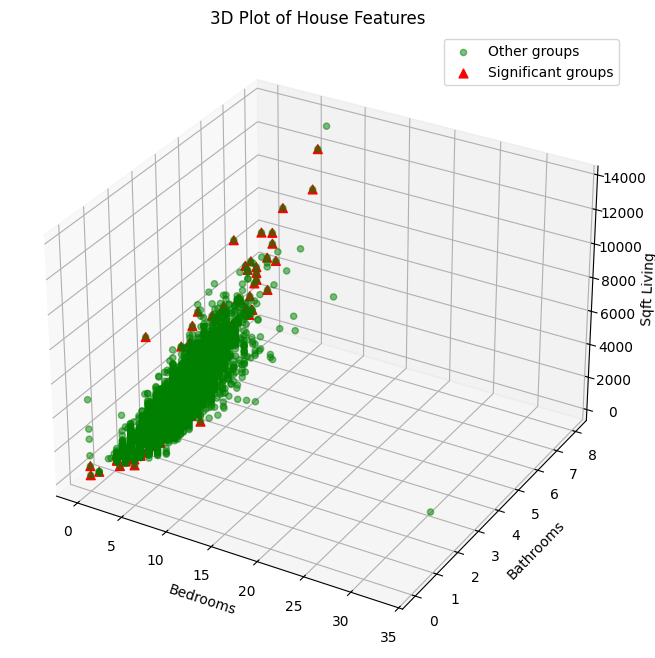

In [6]:
if RUNNING == 'local':
    # Convert Spark DataFrames to Pandas DataFrames
    all_groups = grouped_df.toPandas()
    significant_groups = significant_groups_df.toPandas()

    # Create a 3D plot
    fig = plt.figure(figsize=(12, 8))  # Adjust the figure size
    ax = fig.add_subplot(111, projection='3d')

    # Plot all data points (green, smaller, more transparent)
    ax.scatter(all_groups['bedrooms'], all_groups['bathrooms'], all_groups['sqft_living'], 
               c='g', marker='o', s=20, alpha=0.5, label='Other groups')

    # Plot significant data points (red, larger, less transparent)
    ax.scatter(significant_groups['bedrooms'], significant_groups['bathrooms'], significant_groups['sqft_living'], 
               c='r', marker='^', s=40, alpha=1.0, label='Significant groups')

    # Set labels
    ax.set_xlabel('Bedrooms')
    ax.set_ylabel('Bathrooms')
    ax.set_zlabel('Sqft Living')
    ax.set_title('3D Plot of House Features')
    # Display legend
    ax.legend()

    # Show plot
    plt.show()
    # Save the plot
    fig.savefig(chart_outputs[0])

### ❗️Findings

The analysis of house features reveals significant combinations that strongly influence house prices. The 3D plot visualizes the relationship between bedrooms, bathrooms, and square footage of living space (sqft_living), with red triangles highlighting the most impactful combinations.

Key observations include:

1. High-end homes: There's a clear cluster of significant combinations (red triangles) in the upper range of all three features, indicating that large homes with many bedrooms and bathrooms command premium prices.

2. Size matters: The sqft_living axis shows a strong positive correlation with significant price impacts, suggesting that overall living space is a crucial factor.

3. Diminishing returns: While more bedrooms and bathrooms generally correlate with higher prices, there appears to be a point of diminishing returns, as extremely high numbers of bedrooms or bathrooms are less common among significant groups.

4. Balanced ratios: The most significant combinations seem to maintain a balanced ratio between bedrooms and bathrooms, rather than extremes in either direction.

5. Outliers: A few significant points appear in unexpected areas, such as homes with fewer bedrooms but high square footage, indicating that unique properties can still command high prices.

6. Density distribution: The majority of homes cluster in the lower to mid-range of all features, with significant price impacts becoming more prevalent as values increase across all axes.

This analysis highlights the complex interplay between key house features and their impact on pricing. It suggests that while size is generally a strong predictor of price, the most valuable properties tend to have a well-balanced combination of spacious living areas, multiple bedrooms, and several bathrooms. This insight can be valuable for real estate professionals, developers, and potential buyers in understanding how different feature combinations contribute to a home's market value.

### Spark Job Detail Analysis

#### Physical Plan Analysis

The physical plan of the Spark job reveals the following stages and transformations:

1. **Adaptive Query Execution (AQE)**:
   - The final plan involves an `AdaptiveSparkPlan` indicating that Spark is using AQE for this job. AQE dynamically optimizes the query plan based on runtime statistics.

2. **Filter Operation**:
   - A filter operation is applied to the dataset where `avg_price` is either less than or equal to `199950.0` or greater than or equal to `2750000.0`.

3. **HashAggregate**:
   - The plan includes a `HashAggregate` operation, which groups the data by `bedrooms`, `bathrooms`, and `sqft_living` and computes the average price.

4. **Shuffle and Exchange**:
   - Data is shuffled and repartitioned based on the hash partitioning of the group-by keys (`bedrooms`, `bathrooms`, `sqft_living`). The `Exchange` operation ensures that the data is partitioned correctly for the aggregation.

5. **FileScan**:
   - The data is read from a CSV file using a `FileScan` operation, which reads the columns `price`, `bedrooms`, `bathrooms`, and `sqft_living`.

#### Stage Analysis

The job consists of multiple stages:

1. **Stage 0**:
   - This stage involves reading the data from the CSV file and performing the initial `HashAggregate` operation. The data is then shuffled and repartitioned.

2. **Stage 1**:
   - After the shuffle, the repartitioned data is processed by another `HashAggregate` operation to compute the final average prices.

3. **Stage 2**:
   - The final stage applies the filter operation to retain only the groups with average prices in the bottom 1% or top 1%.

#### Summary

- **Input**: The dataset is read from a CSV file containing columns `price`, `bedrooms`, `bathrooms`, and `sqft_living`.
- **Transformations**: The data undergoes aggregation to compute average prices for combinations of `bedrooms`, `bathrooms`, and `sqft_living`. The results are filtered to identify significant groups.
- **Output**: The filtered significant groups are written to a CSV file.

#### Conclusion

The Spark job efficiently processes and analyzes the house price data by leveraging AQE for dynamic optimization. The job reads the data, aggregates it to compute average prices, and filters the results to identify significant groups. The use of hash partitioning and shuffle operations ensures that the data is correctly partitioned for aggregation, leading to efficient execution of the job. This analysis provides insights into the physical execution plan and stages of the job, highlighting its efficiency and optimization techniques.

In [7]:
significant_groups_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=true
+- == Final Plan ==
   *(2) Filter ((avg_price#95 <= 199950.0) OR (avg_price#95 >= 2750000.0))
   +- *(2) HashAggregate(keys=[bedrooms#20, bathrooms#21, sqft_living#22], functions=[avg(price#19)])
      +- AQEShuffleRead coalesced
         +- ShuffleQueryStage 0
            +- Exchange hashpartitioning(bedrooms#20, bathrooms#21, sqft_living#22, 200), ENSURE_REQUIREMENTS, [plan_id=335]
               +- *(1) HashAggregate(keys=[bedrooms#20, knownfloatingpointnormalized(normalizenanandzero(bathrooms#21)) AS bathrooms#21, sqft_living#22], functions=[partial_avg(price#19)])
                  +- FileScan csv [price#19,bedrooms#20,bathrooms#21,sqft_living#22] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/qwe/Desktop/COMP7305/L10/localspark/programs/kc-house-eda/..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<price:double,bedrooms:int,bathrooms:double,sqft_living:int>
+- ==

---

## Question 2: Does the impact of house location (Zipcode) on house prices differ significantly across different construction years?

**Objective:** Investigate the impact of house location on house prices across different construction years and identify the differences in location impact over different construction years.

**Analysis Steps:**

1. Group and Aggregate:
   - Select columns: zipcode, yr_built, and price.
   - Group by zipcode and yr_built, and calculate the average house price using groupBy and agg.

2. Pivot:
   - Create a pivot table to compare the price differences across different construction years using pivot.

3. Export Results:
   - Export the results to a CSV file.

**Spark Job Brief Analysis:**

- Physical Plan: select -> groupBy -> agg -> pivot -> write
- Number of Stages: 2
  - The first stage includes select, groupBy, and agg, which triggers a shuffle event.
  - The second stage includes pivot and write.

**Summary:** By analyzing the impact of house location (zipcode) on house prices across different construction years, we can identify temporal variations in the influence of location, providing a basis for decision-making.

### EDA Process

In [8]:
# Select the required columns
df_selected = df.select("zipcode", "yr_built", "price")

# Step 1: Group by zipcode and yr_built, and calculate the average house price
grouped_df = df_selected.groupBy("zipcode", "yr_built").agg(avg("price").alias("avg_price"))

# Step 2: Use pivot to perform data pivoting to compare house price differences across different construction years
pivot_df = grouped_df.groupBy("zipcode").pivot("yr_built").avg("avg_price")

# Save the results
pivot_df.coalesce(1).write.csv(question_outputs[1], header=True, mode='overwrite', sep=',')
pivot_df.show(n=3)

+-------+----+----+----+----+----+--------+----+----+--------+----+--------+--------+--------+--------+--------+---------+----+--------+--------+----+------------------+--------+--------+--------+--------+----+--------+--------+--------+--------+--------+--------+--------+----+--------+--------+--------+--------+---------+--------+--------+--------+--------+--------+--------+--------+------------------+------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+--------+------------------+--------+-----------------+------------------+--------+-----------------+--------+-----------------+-----------------+-----------------+--------+------------------+-----------------+------------------+----------+-----------------+---------+--------+--------

### Spark Job Detail Analysis

#### Physical Plan Analysis
The physical plan involves multiple aggregation stages with hash partitioning and shuffle operations to ensure data is distributed correctly for the pivot operation. The key steps include:
- Initial aggregation to compute average prices grouped by `zipcode` and `yr_built`.
- Hash partitioning by `zipcode` and `yr_built` to prepare data for the pivot operation.
- Final aggregation and pivot to structure the data by construction year.

#### Stage Analysis
- **Stage 0:** 
  - **Operation:** Aggregates average house prices grouped by `zipcode` and `yr_built`.
  - **Shuffle:** Hash partitions data by `zipcode` and `yr_built` into 200 partitions.
- **Stage 1:**
  - **Operation:** Further aggregates the partitioned data and performs partial pivoting.
  - **Shuffle:** Hash partitions data by `zipcode` into 200 partitions.
- **Stage 2:**
  - **Operation:** Final aggregation and pivoting to create the output structure.
  - **Shuffle:** Reads coalesced shuffle data from Stage 1 for final processing.

#### Summary
The job consists of three main stages involving multiple aggregation and shuffle operations. The process ensures efficient data distribution and aggregation to compute average house prices for each `zipcode` across different construction years.

#### Conclusion
The Spark job effectively handles the complexity of pivoting large datasets by leveraging multiple aggregation stages and shuffle operations. This approach ensures the computation is scalable and can handle various construction years and `zipcode` combinations efficiently.

In [9]:
pivot_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [zipcode#33, __pivot_avg(avg_price) AS `avg(avg_price)`#427[0] AS 1900#428, __pivot_avg(avg_price) AS `avg(avg_price)`#427[1] AS 1901#429, __pivot_avg(avg_price) AS `avg(avg_price)`#427[2] AS 1902#430, __pivot_avg(avg_price) AS `avg(avg_price)`#427[3] AS 1903#431, __pivot_avg(avg_price) AS `avg(avg_price)`#427[4] AS 1904#432, __pivot_avg(avg_price) AS `avg(avg_price)`#427[5] AS 1905#433, __pivot_avg(avg_price) AS `avg(avg_price)`#427[6] AS 1906#434, __pivot_avg(avg_price) AS `avg(avg_price)`#427[7] AS 1907#435, __pivot_avg(avg_price) AS `avg(avg_price)`#427[8] AS 1908#436, __pivot_avg(avg_price) AS `avg(avg_price)`#427[9] AS 1909#437, __pivot_avg(avg_price) AS `avg(avg_price)`#427[10] AS 1910#438, __pivot_avg(avg_price) AS `avg(avg_price)`#427[11] AS 1911#439, __pivot_avg(avg_price) AS `avg(avg_price)`#427[12] AS 1912#440, __pivot_avg(avg_price) AS `avg(avg_price)`#427[13] AS 1913#441, __pivot_avg(avg_price) AS `avg(avg

In [10]:
# If this is executed in a local environment, the following code with more analysis will be executed
if RUNNING == 'local':
    # Convert Spark DataFrame to Pandas DataFrame
    pivot_pd_df = pivot_df.toPandas()

    # Backfill missing values
    pivot_pd_df = pivot_pd_df.fillna(method='bfill', axis=1)
    pivot_pd_df = pivot_pd_df.fillna(method='ffill', axis=1)

    # Convert Pandas DataFrame back to Spark DataFrame
    filled_pivot_df = spark.createDataFrame(pivot_pd_df)

    # Save the results
    filled_pivot_df.coalesce(1).write.csv(os.path.join(output_dir, f'q2_more.csv'), header=True, mode='overwrite', sep=',')
    filled_pivot_df.show(n=3)

+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+------------------+------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+--------+--------+-----------------+-----------------+------------------+------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+--------+------------------+--------+-----------------+------------------+--------+-----------------+--------+-----------------+-----------------+-----------------+--------+------------------+-----------------

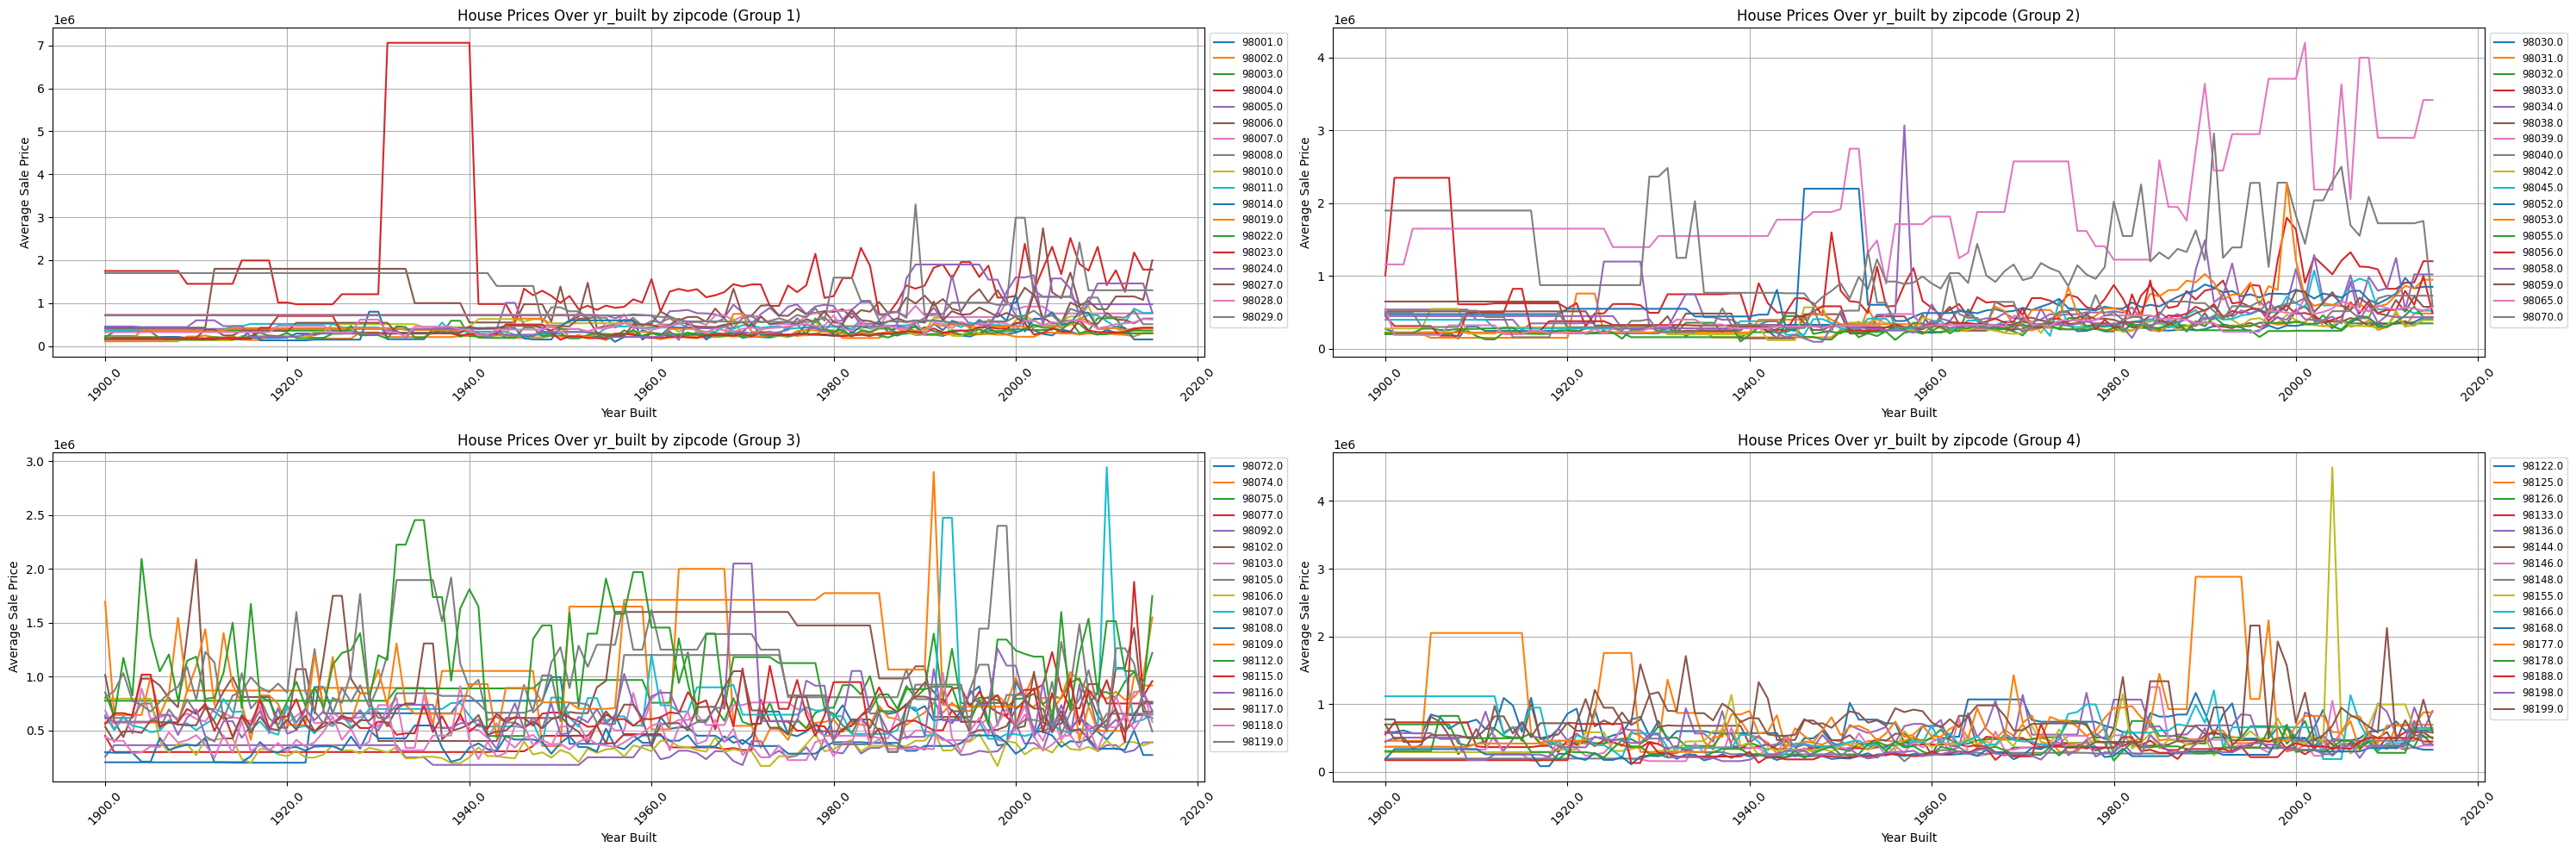

In [11]:
if RUNNING == 'local':
    # Sort by zipcode in ascending order
    pivot_pd_df.sort_values(by='zipcode', inplace=True)

    # Divide the chart into 4 subplots, 2 rows and 2 columns
    num_parts = 4
    num_rows, num_cols = 2, 2
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(30, 10))

    # Calculate the number of zipcodes in each subplot
    num_zipcodes = len(pivot_pd_df)
    zipcodes_per_part = (num_zipcodes + num_parts - 1) // num_parts  # Round up

    # Set zipcode as the index
    pivot_pd_df.set_index('zipcode', inplace=True)

    # Transpose DataFrame for plotting
    pivot_pd_df_transpose = pivot_pd_df.transpose()

    # Get the list of years
    years = [int(i) for i in pivot_pd_df_transpose.index.tolist()]

    # Plot each subplot
    for i in range(num_parts):
        start_idx = i * zipcodes_per_part
        end_idx = min((i + 1) * zipcodes_per_part, num_zipcodes)
        zipcodes = pivot_pd_df.index[start_idx:end_idx]

        ax = axs[i // num_cols, i % num_cols]  # Get the axis of the current subplot
        for zipcode in zipcodes:
            ax.plot(years, pivot_pd_df_transpose[zipcode], label=str(zipcode))

        # Add legend
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='small')

        # Add title and labels
        ax.set_title(f'House Prices Over yr_built by zipcode (Group {i + 1})')
        ax.set_xlabel('Year Built')
        ax.set_ylabel('Average Sale Price')

        # Rotate x-axis labels for better display
        ax.set_xticklabels(ax.get_xticks(), rotation=45)

        # Show grid
        ax.grid(True)

    # Adjust layout to avoid overlap
    plt.tight_layout()
    
    # Display the chart
    plt.show()

    # Save the chart
    fig.savefig(chart_outputs[1])

### ❗️Findings

The analysis of house prices across different zipcodes and construction years reveals significant variations in the impact of location over time. Key observations include:

1. Price Volatility: Newer constructions (post-2000) show much higher price volatility across zipcodes compared to older homes, suggesting that location has become increasingly important in recent years.

2. Diverging Trends: Some zipcodes (e.g., the pink line in Group 2) show dramatic price increases for newer constructions, while others remain relatively stable, indicating growing disparities between desirable and less desirable areas.

3. Historical Stability: Older homes (pre-1950) generally show more consistent prices across zipcodes, implying that location played a less significant role in pricing for older constructions.

4. Periodic Spikes: All groups show occasional sharp spikes in prices for specific years and zipcodes, possibly reflecting unique developments or local economic factors.

5. Overall Upward Trend: Most zipcodes show a general upward trend in prices for newer constructions, but the rate of increase varies significantly.

6. Group Differences: The four groups show distinct patterns, with Group 1 having the highest overall prices and most volatility, while Groups 3 and 4 show more moderate price levels and variations.

These findings highlight the complex relationship between location and construction year in determining house prices. The increasing divergence in prices across zipcodes for newer constructions underscores the growing importance of location in the housing market, likely reflecting changes in urban development, neighborhood gentrification, and shifting buyer preferences over time. This analysis provides valuable insights for real estate professionals, urban planners, and policymakers in understanding long-term housing market dynamics and location-based value trends.

---

## Question 3: What is the impact of house renovation or remodeling on house prices?

**Objective:** Analyze the impact of house renovation or remodeling on house prices and evaluate the value added by renovation or remodeling.

**Analysis Steps:**

1. **Data Preprocessing:**
   - Filter records with non-empty house prices to ensure data integrity.
   - Fill missing values in the `yr_renovated` column with the maximum value of the `yr_built` column to ensure data consistency.

2. **Feature Engineering:**
   - Create an `IsRenovated` column to identify whether a house has been renovated (`yr_renovated` greater than `yr_built`).

3. **Grouping and Aggregation:**
   - Group by the `IsRenovated` column and calculate the average and standard deviation of house prices.

4. **Calculate Price Differences:**
   - Calculate the average price difference before and after renovation or remodeling to evaluate the value added by renovation or remodeling.

5. **Export Results:**
   - Export the grouped and aggregated results to a CSV file for further analysis and sharing.

**Spark Job Brief Analysis:**

- **Physical Plan:** `filter` -> `groupBy` -> `agg` -> `write`
- **Number of Stages:** 2
  - The first stage includes `filter` and `groupBy`, which will trigger a shuffle event.
  - The second stage includes `agg` and `write`.

**Summary:** This analysis provides a reference for homeowners and investors on the return on investment of renovations. By performing data preprocessing, feature engineering, and grouping and aggregation analysis, the impact of house renovation or remodeling on house prices can be evaluated. Exporting the results to a CSV file allows for further analysis and sharing. These analysis results can provide valuable insights for homeowners and investors on the return on investment of renovations.

In [12]:
# Data preprocessing
# Filter out records with non-null price
df = df.filter(df.price.isNotNull())
# Fill missing values in yr_renovated
df = df.fillna({'yr_renovated': df.agg({'yr_built': 'max'}).collect()[0][0]})

# Feature engineering
# Create IsRenovated column to indicate whether the house is renovated; 1 for renovated, 0 for not renovated
df = df.withColumn("IsRenovated", when(col("yr_renovated") > col("yr_built"), 1).otherwise(0))

# Grouping and aggregation
# Group by IsRenovated and calculate the average and standard deviation of price
grouped_df = df.groupBy("IsRenovated").agg(
    avg("price").alias("AveragePrice"),
    stddev("price").alias("PriceStdDev")
)

# Calculate the price difference before and after renovation
price_difference = grouped_df.collect()
renovated_price = price_difference[0]['AveragePrice']
not_renovated_price = price_difference[1]['AveragePrice']
price_diff = renovated_price - not_renovated_price

# Export the results to a CSV file
grouped_df.coalesce(1).write.csv(question_outputs[2], header=True, mode='overwrite', sep=',')

# Print the results
grouped_df.show()
print(f"Average price for renovated houses: {renovated_price}")
print(f"Average price for not renovated houses: {not_renovated_price}")
print(f"Price difference due to renovation: {price_diff}")

+-----------+-----------------+-----------------+
|IsRenovated|     AveragePrice|      PriceStdDev|
+-----------+-----------------+-----------------+
|          1|760379.0295404814|607734.7673609434|
|          0|530360.8181554665|349578.0148636167|
+-----------+-----------------+-----------------+

Average price for renovated houses: 760379.0295404814
Average price for not renovated houses: 530360.8181554665
Price difference due to renovation: 230018.21138501493


### ❗️Findings

The analysis of the impact of house renovation or remodeling on house prices reveals significant differences between renovated and non-renovated properties:

1. Price Increase: Renovated houses show a substantial average price increase of $230,018.21 compared to non-renovated houses. This represents a 43.4% premium for renovated properties, indicating that renovation generally adds significant value to a home.

2. Average Prices: The average price for renovated houses ($760,379.03) is considerably higher than that of non-renovated houses ($530,360.82), further emphasizing the positive impact of renovations on property values.

3. Price Variability: Renovated houses exhibit a much higher standard deviation in prices ($607,734.77) compared to non-renovated houses ($349,578.01). This suggests that the impact of renovations on price can vary widely, possibly due to factors such as the extent and quality of renovations, location, or original condition of the property.

4. Investment Potential: The substantial price difference due to renovation implies that there could be significant potential for return on investment through home improvements, though the high variability suggests that outcomes may not be uniform.

5. Market Segmentation: The clear price distinction between renovated and non-renovated properties indicates a potential segmentation in the housing market, with renovated homes likely appealing to a different buyer demographic.

These findings highlight the significant positive impact of renovations on house prices, while also revealing the complexity and variability in this relationship. The results suggest that homeowners and investors should carefully consider the potential value added by renovations, while also being aware that the outcomes can vary considerably. This analysis provides valuable insights for real estate professionals, homeowners considering renovations, and potential buyers in understanding the relationship between home improvements and market value.

In [13]:
grouped_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=true
+- == Final Plan ==
   *(2) HashAggregate(keys=[IsRenovated#9407], functions=[avg(price#19), stddev(price#19)])
   +- AQEShuffleRead coalesced
      +- ShuffleQueryStage 0
         +- Exchange hashpartitioning(IsRenovated#9407, 200), ENSURE_REQUIREMENTS, [plan_id=1040]
            +- *(1) HashAggregate(keys=[IsRenovated#9407], functions=[partial_avg(price#19), partial_stddev(price#19)])
               +- *(1) Project [price#19, CASE WHEN (coalesce(yr_renovated#32, 2015) > yr_built#31) THEN 1 ELSE 0 END AS IsRenovated#9407]
                  +- *(1) Filter isnotnull(price#19)
                     +- FileScan csv [price#19,yr_built#31,yr_renovated#32] Batched: false, DataFilters: [isnotnull(price#19)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/qwe/Desktop/COMP7305/L10/localspark/programs/kc-house-eda/..., PartitionFilters: [], PushedFilters: [IsNotNull(price)], ReadSchema: struct<price:double,yr_built:int,yr_renov

---

## Question 4: Identifying the Top-5 Features Related to House Prices

**Objective:** Through data analysis, identify the top five features most related to house prices to support house pricing, market analysis, and investment decisions.

**Analysis Steps:**

1. **Data Preprocessing:**
   - Handle missing values and outliers to ensure data quality.
   - Appropriately process numerical and categorical features (e.g., standardization, encoding).

2. **Feature Selection:**
   - Use correlation analysis (e.g., Pearson correlation coefficient) to calculate the correlation between each feature and house prices.
   - Select the top five features that are highly correlated with house prices.

3. **Visualization Analysis:**
   - Use visualization tools to display the relationship between the most correlated features and house prices.

4. **Export Results:**
   - Export the results of the correlation analysis to a CSV file.

**Spark Job Brief Analysis:**

- **Physical Plan:** `filter` -> `select` -> `corr` -> `write`
- **Number of Stages:** 2
  - The first stage includes `filter` and `select`, which will trigger a shuffle event.
  - The second stage includes `corr` and `write`.

**Summary:** This analysis identifies the top five features most related to house prices through correlation analysis, providing data support for house pricing, market analysis, and investment decisions.

In [14]:
# Data preprocessing
# Filter out records with non-null price
df = df.filter(df.price.isNotNull())

# Handle missing values (choose a filling strategy based on specific needs)
df = df.fillna(0)

# Feature selection
# Calculate the correlation between each numeric feature and price
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
correlations = []
for feature in numeric_features:
    if feature != 'price':
        corr_value = df.stat.corr('price', feature)
        correlations.append((feature, corr_value))

# Convert the correlation results to a DataFrame
correlation_df = spark.createDataFrame(correlations, ["Feature", "Correlation"])

# Calculate the correlation of all features with price and sort by correlation in descending order
correlated_features = correlation_df.orderBy(col("Correlation").desc())

# Export the results to a CSV file
correlated_features.coalesce(1).write.csv(question_outputs[3], header=True, mode='overwrite', sep=',')

# Print the top 5 features with the highest correlation
print("[+] Top 5 highly correlated features with price:")
correlated_features.show(n=5)

[+] Top 5 highly correlated features with price:
+-------------+------------------+
|      Feature|       Correlation|
+-------------+------------------+
|  sqft_living|0.7020350546118005|
|        grade|0.6674342560202353|
|   sqft_above|0.6055672983560784|
|sqft_living15|0.5853789035795692|
|    bathrooms|0.5251375054139628|
+-------------+------------------+
only showing top 5 rows



### ❗️Findings

The analysis of the top features most correlated with house prices reveals several important insights:

1. Living Space Dominance: The most influential factor is 'sqft_living' (living space square footage) with a strong positive correlation of 0.70. This underscores the significant impact of a home's size on its price.

2. Quality Matters: 'Grade', which likely refers to the overall quality or condition of the house, emerges as the second most important feature with a correlation of 0.67. This suggests that the general condition and finish of a house significantly drives its price.

3. Above-Ground Space: 'sqft_above' (square footage above ground) is the third most correlated feature (0.61), indicating that above-ground living space is particularly valued in the market.

4. Recent Renovations: 'sqft_living15', which might represent the living area after recent renovations or for neighboring homes, shows a strong correlation (0.59). This suggests that recent updates or comparisons to nearby properties play a role in pricing.

5. Bathroom Count: The number of 'bathrooms' rounds out the top 5 with a correlation of 0.53, highlighting the importance of this specific feature in determining house value.

Interestingly, all top features show positive correlations above 0.5, indicating strong relationships with price. The absence of location-based features in the top 5 is somewhat surprising, suggesting that these physical attributes may be more universally valued across different areas. The prominence of size-related features (three out of five) emphasizes the crucial role of space in determining a home's value. This analysis provides valuable insights for real estate professionals, homeowners, and potential buyers in understanding the key drivers of house prices, and can guide decision-making in home improvements, purchases, and market analysis.

### Spark Job Detail Analysis

#### Physical Plan Analysis
- The plan uses an AdaptiveSparkPlan, indicating dynamic optimization.
- A Sort operation is performed on the 'Correlation' column in descending order.
- An Exchange operation with range partitioning is used for data distribution.
- The data source is an existing RDD containing 'Feature' and 'Correlation' columns.

#### Stage Analysis
- Stage 1: RDD scan and initial data processing
- Stage 2: Exchange (shuffle) for data redistribution
- Stage 3: Sorting of correlation results

#### Summary
- The job efficiently processes correlation data using adaptive planning.
- It leverages distributed sorting and partitioning for scalability.
- The use of an existing RDD suggests prior data preparation or caching.

#### Conclusion
This Spark job is optimized for large-scale correlation analysis. The adaptive plan and efficient data distribution strategy indicate it's designed to handle substantial datasets while maintaining performance. The focus on sorting correlation results aligns with the goal of identifying top features related to house prices.

In [15]:
correlated_features.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [Correlation#14802 DESC NULLS LAST], true, 0
   +- Exchange rangepartitioning(Correlation#14802 DESC NULLS LAST, 200), ENSURE_REQUIREMENTS, [plan_id=2151]
      +- Scan ExistingRDD[Feature#14801,Correlation#14802]


